In [1]:
import itertools, pathlib, pickle, copy, random, os, glob , sys
from time import time

import pandas as pd
import numpy as np
import tensorflow as tf

import sklearn 
from sklearn.metrics import precision_recall_fscore_support

import keras 
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Input, Embedding, CuDNNLSTM, CuDNNGRU,  GlobalMaxPooling1D, GlobalAveragePooling1D,Reshape



Using TensorFlow backend.


In [2]:
def gen_data(n, signal=9, length=10, dim=10 ):
    x = []
    y = []
    for i in range(0,n):
        seq = np.random.randint(0,dim,length)
        loc = np.where(seq==signal) 
        x.append(seq)
        try:
            loc_signal = min(loc[0])            
            if min(loc[0]) == length - 1:
                y.append(0)
            else:
                y.append( (seq[min(loc[0]) + 1 ] > (dim-1)/2) + 0  )
        except:
            y.append(0)
    x = pad_sequences(x)
    y = np.asarray(y)
    return x,y 

In [3]:
def PCI(x_train,y_train, x_val, y_val, x_future, y_future):
    input_x = Input(shape=(10,))
    GRU_x = Embedding(15,3,input_length=10)(input_x)
    GRU_x = CuDNNGRU(15)(GRU_x)
    GRU_x = Activation('tanh')(GRU_x)
    GRU_x = Dropout(0.2)(GRU_x)

    GRU_x = Dense(1, activation='sigmoid')(GRU_x)

    GRU_model = keras.models.Model(inputs=[input_x], outputs=[GRU_x] )

    GRU_model.compile(
        loss='binary_crossentropy', 
        optimizer=keras.optimizers.adam(0.01),
        metrics=['accuracy'])

    GRU_model.fit(
        x_train, 
        y_train, 
        batch_size=200, 
        epochs = 50,
        validation_data=(x_val, y_val) , 
        shuffle=True, 
        verbose = 0)
    acc_val = GRU_model.evaluate(x_val,y_val)[1]
    acc_future = GRU_model.evaluate(x_future,y_future)[1]
    PCI = abs(acc_val- acc_future)
    
    return [acc_val, acc_future, PCI]


In [4]:
np.random.seed(1)
n = 500
X_train = [] 
Y_train = []
X_val = [] 
Y_val = []
for t in range(0,5):
    tmp_x, tmp_y = gen_data(n,signal=9)
    X_train.append(tmp_x)
    Y_train.append(tmp_y)
    
    tmp_x, tmp_y = gen_data(n,signal=9)
    X_val.append(tmp_x)
    Y_val.append(tmp_y)
    
for t in range(5,10):
    tmp_x, tmp_y = gen_data(n,signal=8)
    X_train.append(tmp_x)
    Y_train.append(tmp_y)
    
    tmp_x, tmp_y = gen_data(n,signal=8)
    X_val.append(tmp_x)
    Y_val.append(tmp_y)

output = np.zeros((9,4))

for i in range(0,9):
    print("Period:" + str(i))
    tmp = PCI(X_train[i], Y_train[i], X_val[i], Y_val[i] ,X_val[i+1], Y_val[i+1]) 
    tmp.insert(0,i+1)
    output[i] = tmp
    print(output[i])
   

Period:0
500/500 [==============================] - 0s 40us/step
[1.    1.    0.998 0.002]
Period:1
500/500 [==============================] - 0s 42us/step
[2.    0.998 0.998 0.   ]
Period:2
500/500 [==============================] - 0s 40us/step
[3. 1. 1. 0.]
Period:3
500/500 [==============================] - 0s 42us/step
[4.    0.974 0.97  0.004]
Period:4
500/500 [==============================] - 0s 44us/step
[5.   0.97 0.56 0.41]
Period:5
500/500 [==============================] - 0s 44us/step
[6.00000000e+00 9.90000000e-01 9.90000000e-01 4.76837125e-10]
Period:6
500/500 [==============================] - 0s 44us/step
[7.00000000e+00 9.88000000e-01 9.92000000e-01 4.00000048e-03]
Period:7
500/500 [==============================] - 0s 46us/step
[8.00e+00 9.98e-01 9.94e-01 4.00e-03]
Period:8
500/500 [==============================] - 0s 44us/step
[9.00e+00 9.96e-01 1.00e+00 4.00e-03]


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


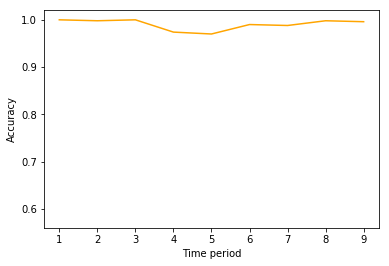

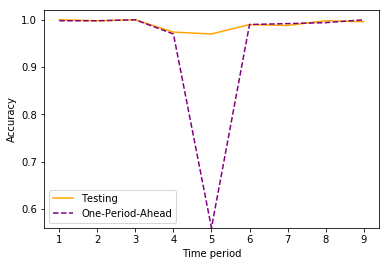

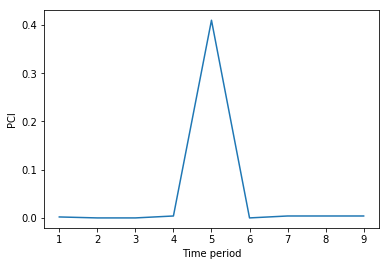

In [24]:
import matplotlib.pyplot as plt

df = pd.DataFrame(output, columns=["time","acc_current","acc_next","PCI"])

fig1 = df.plot(x='time',y='acc_current',legend=False, color = 'orange')
fig1.set_xlabel("Time period")
fig1.set_ylabel("Accuracy")
fig1.set_ylim(0.56,1.02)
print(fig1)
fig1.get_figure().savefig("fig1.png")

fig2 = df.plot(x='time',y=['acc_current', 'acc_next'],style=['-','--'] ,color=['orange','purple'])
fig2.set_xlabel("Time period")
fig2.set_ylabel("Accuracy")
fig2.set_ylim(0.56,1.02)
fig2.legend(["Testing","One-Period-Ahead"])
print(fig2)
fig2.get_figure().savefig("fig2.png")

fig3 = df.plot(x='time',y='PCI',legend=False)
fig3.set_xlabel("Time period")
fig3.set_ylabel("PCI")
print(fig3)
fig3.get_figure().savefig("fig3.png")
